In [1]:
import numpy as np
import common_functions
from scipy.ndimage import rotate
import multiprocessing
import sys
import skimage as sk
import tifffile as tiff
import warnings
from functools import partial
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import norm
import statistics
from copy import copy


In [2]:
time_dome = str(4)
folder_and_dome = str('./../../../../Desktop/dome70_tp'+time_dome+'_fallingline/70_denoised_tp')
wd = folder_and_dome + time_dome

In [7]:
image = sk.io.imread(wd+'.tif')
image_r = common_functions.get_image_r(image)

total_dots = sk.io.imread(wd+'_apical_dots_total_1.tif')
total_dots_r = common_functions.get_image_r(total_dots)

In [6]:
gaussian = common_functions.get_3D_gaussian(total_dots)
gaussian_r = common_functions.get_image_r(gaussian)

In [125]:
### skeleton 3d

# skeleton = sk.morphology.skeletonize_3d(gaussian)
# tiff.imwrite(wd+'_apical_dots_total_gaussian_1_skeleton3d.tif', skeleton)


In [130]:
# ### skeleton 2d
# skeleton_2d = []
# for i in gaussian_r:
#     try:
#         skeleton_2d.append(sk.morphology.skeletonize(i))
#     except:
#         skeleton_2d.append(np.zeros((i.shape)))


# skeleton_2d = np.transpose(skeleton_2d, axes=(1,2,0))
# tiff.imwrite(wd+'_apical_dots_total_gaussian_1_skeleton2d.tif', skeleton_2d)


In [126]:
# tiff.imwrite(wd+'_apical_dots_total_gaussian_1.tif', gaussian)
# tiff.imwrite(wd+'_apical_dots_total_epithelial_1.tif', gaussian*image)
# tiff.imwrite(wd+'_apical_dots_total_gaussian_1_skeleton3d.tif', skeleton)


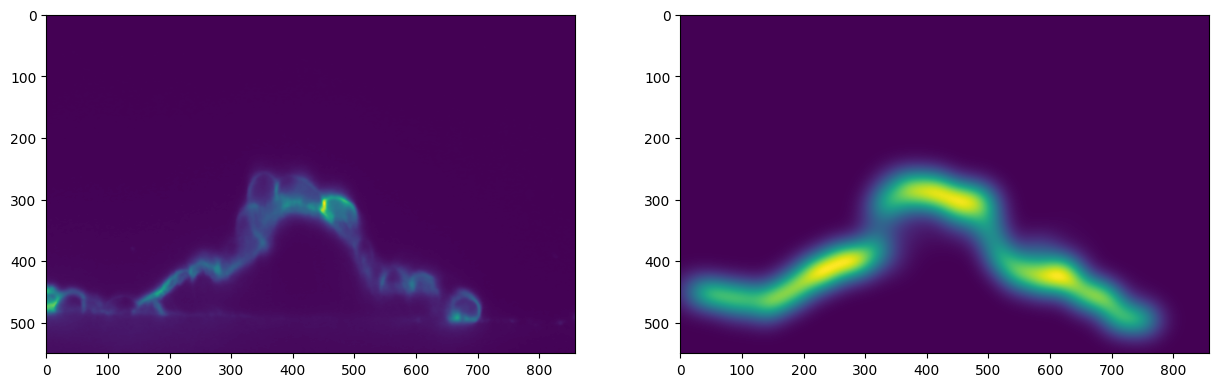

In [205]:
y = 535

plt.figure(figsize=(15,15))
plt.subplot(221)
plt.imshow(image_r[y])
plt.subplot(222)
plt.imshow(gaussian_r[y])

# plt.subplot(223)
# plt.imshow(sk.morphology.skeletonize(gaussian_r[y]))


/tmp/ipykernel_76908/3499830895.py:73: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


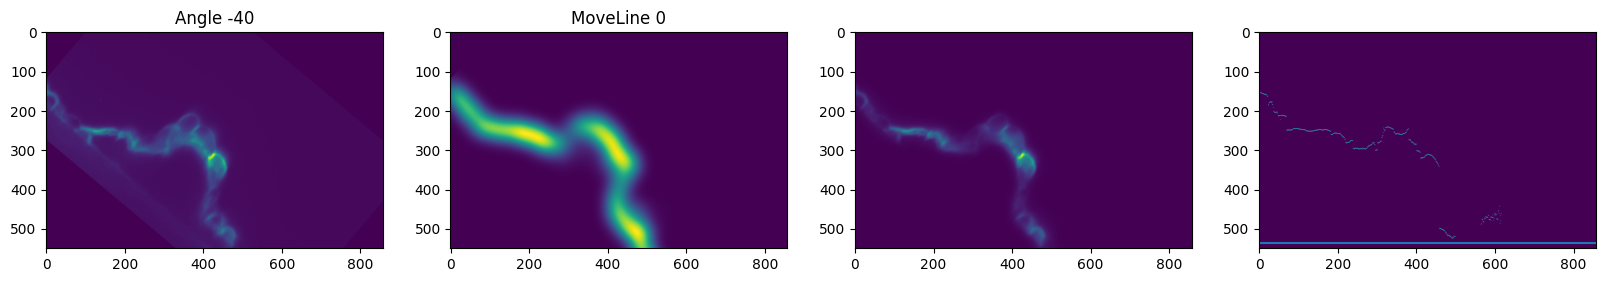

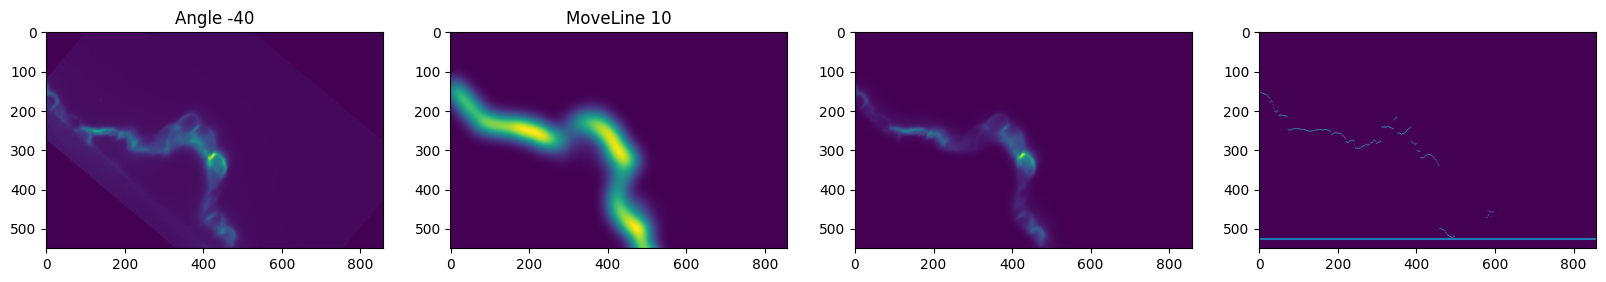

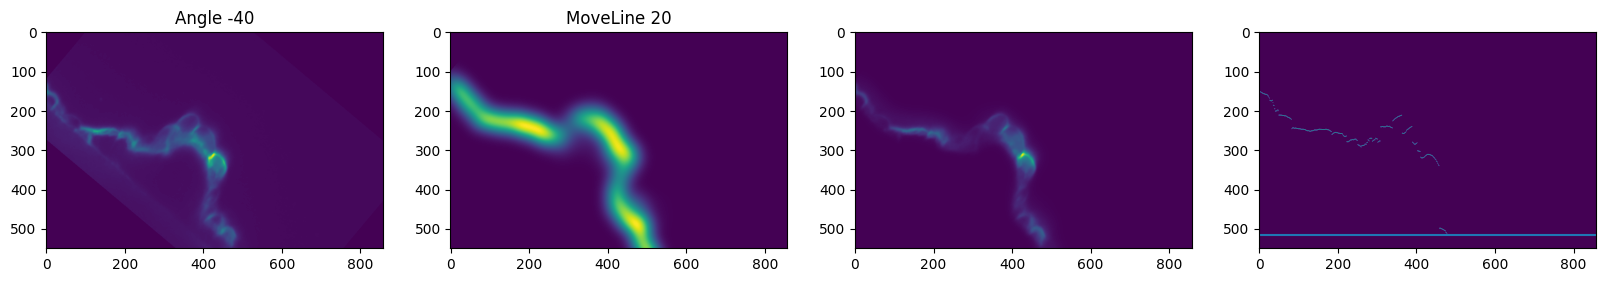

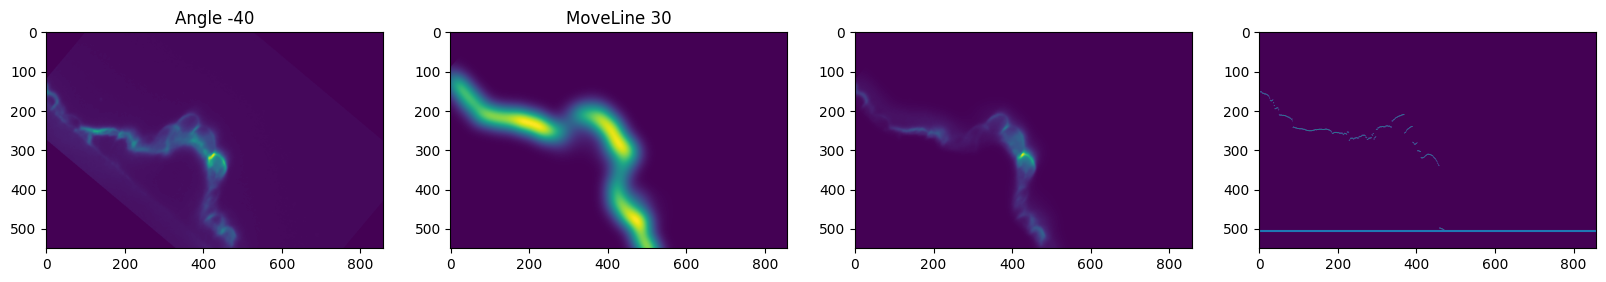

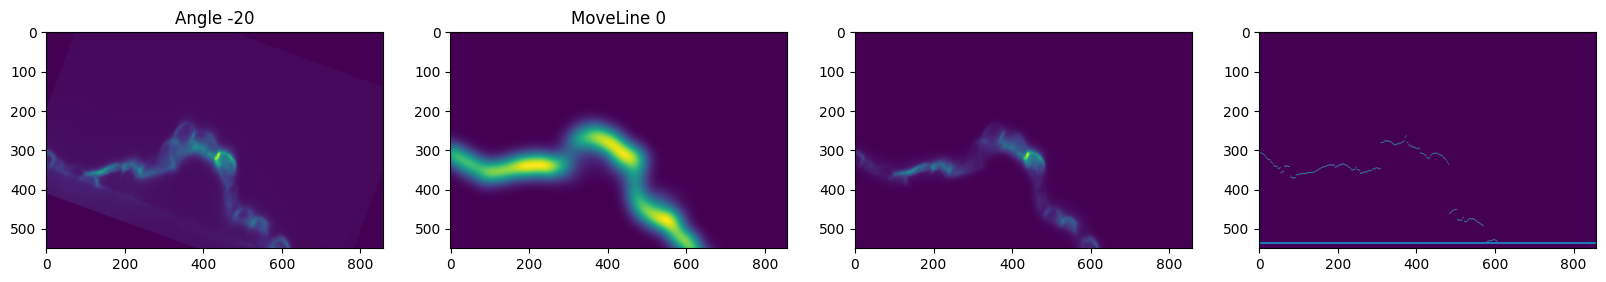

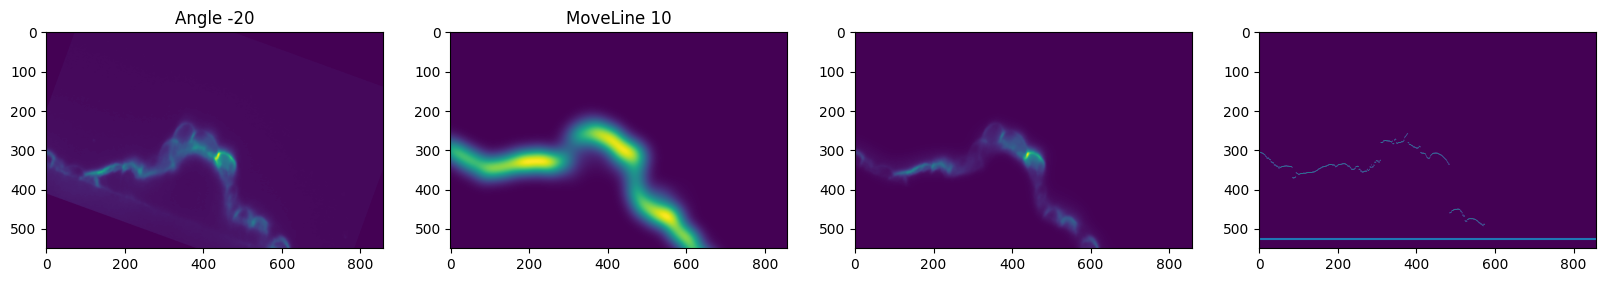

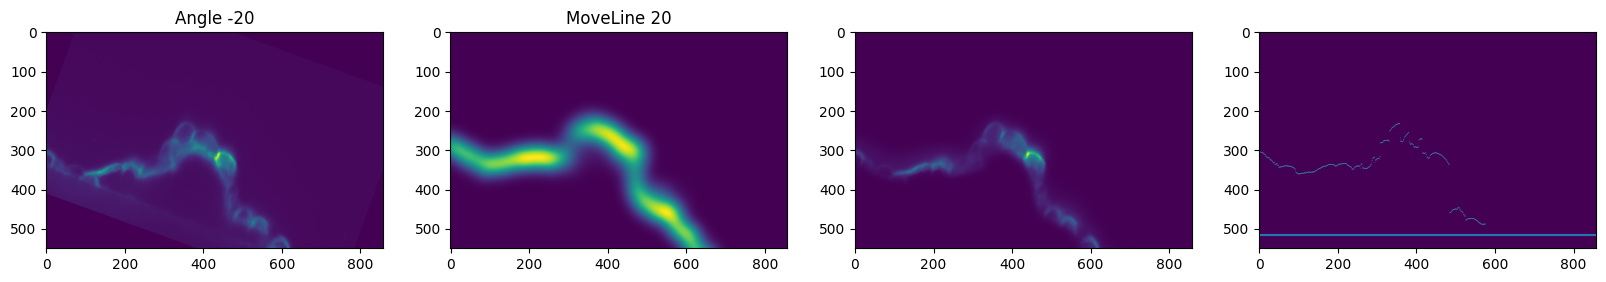

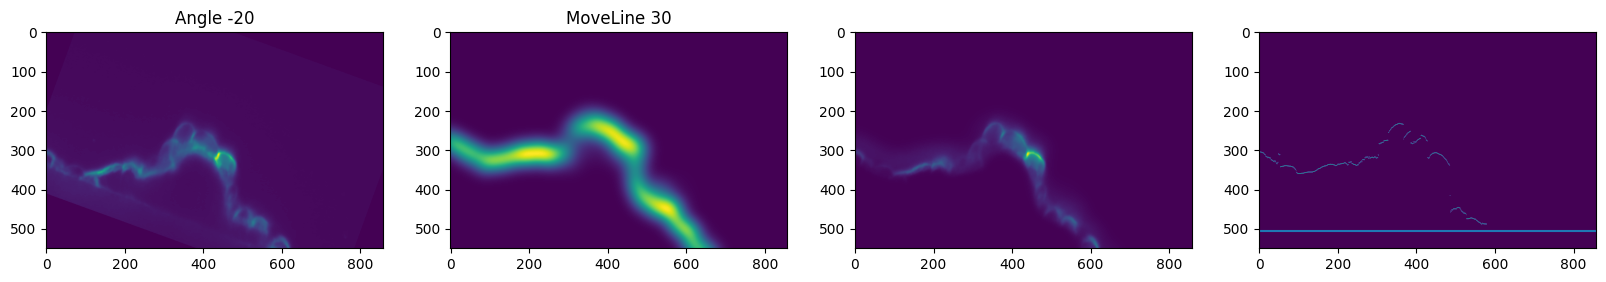

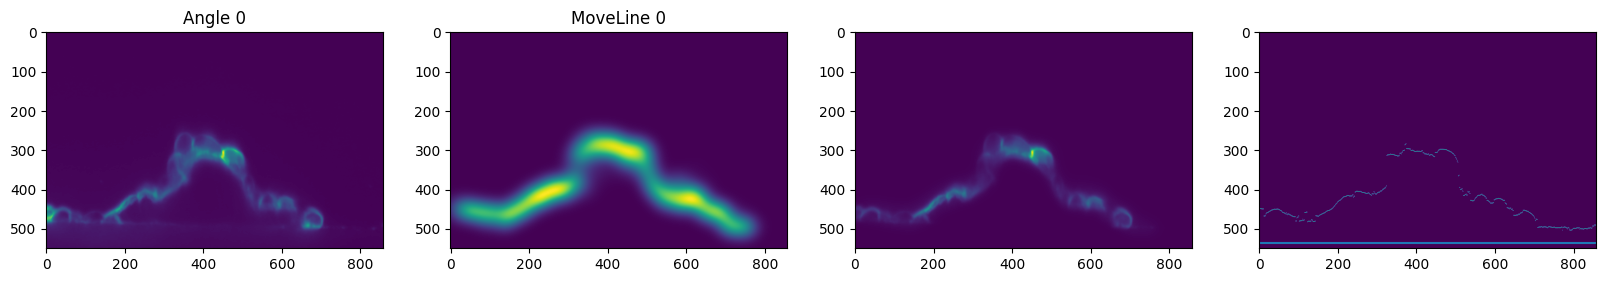

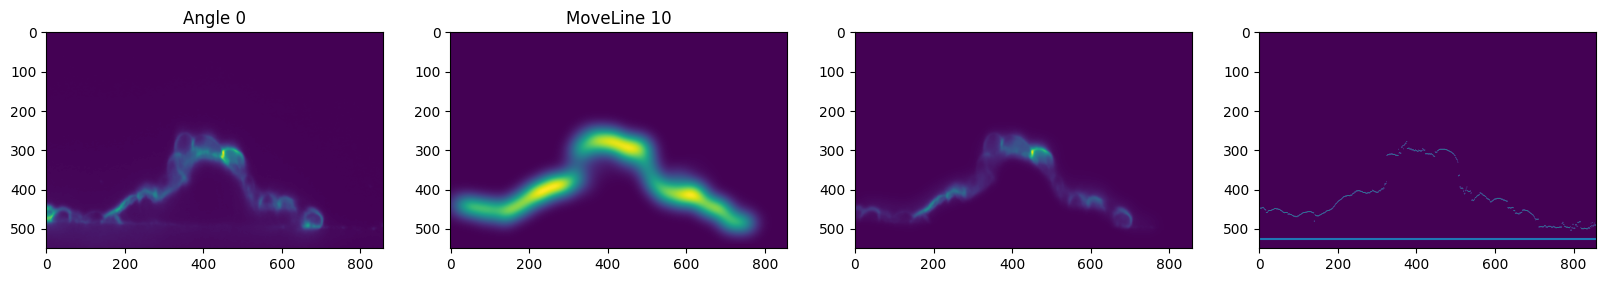

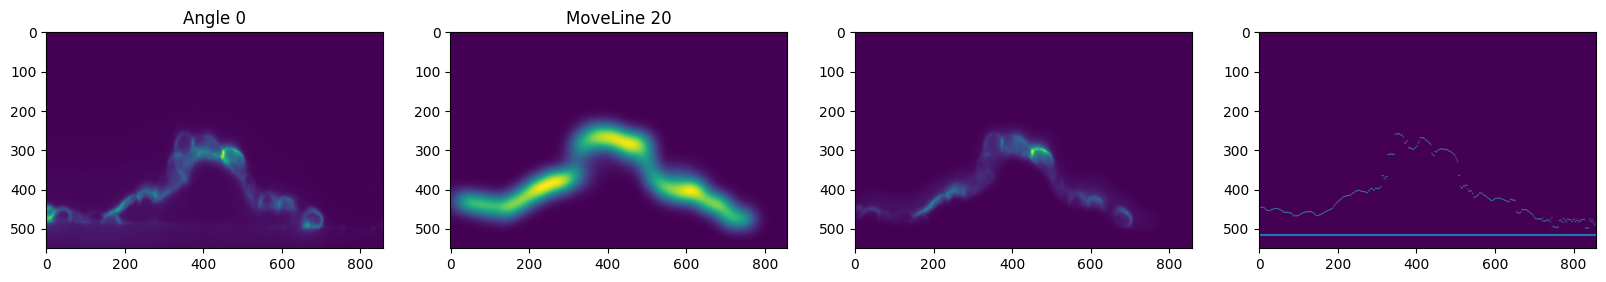

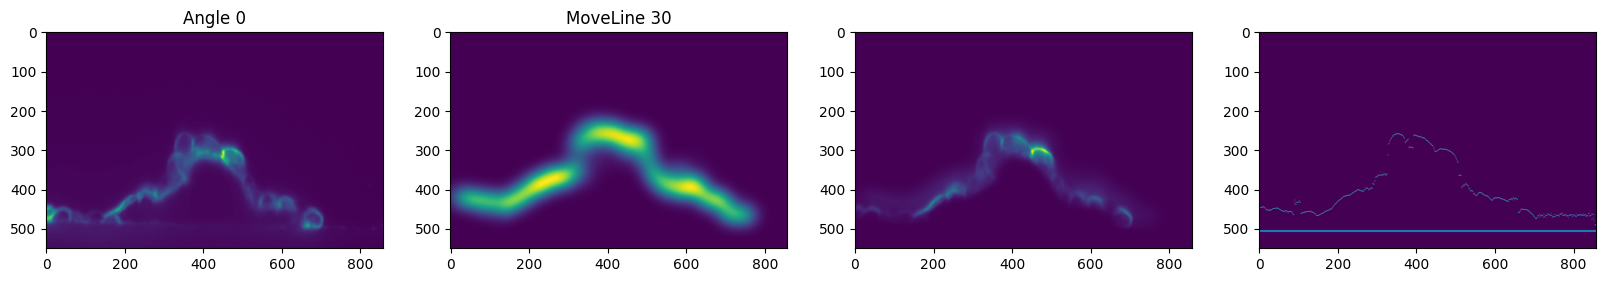

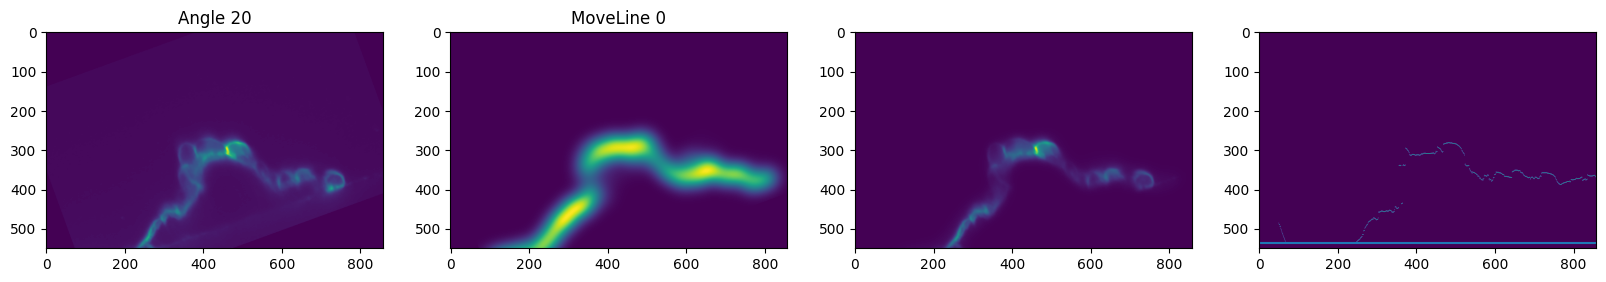

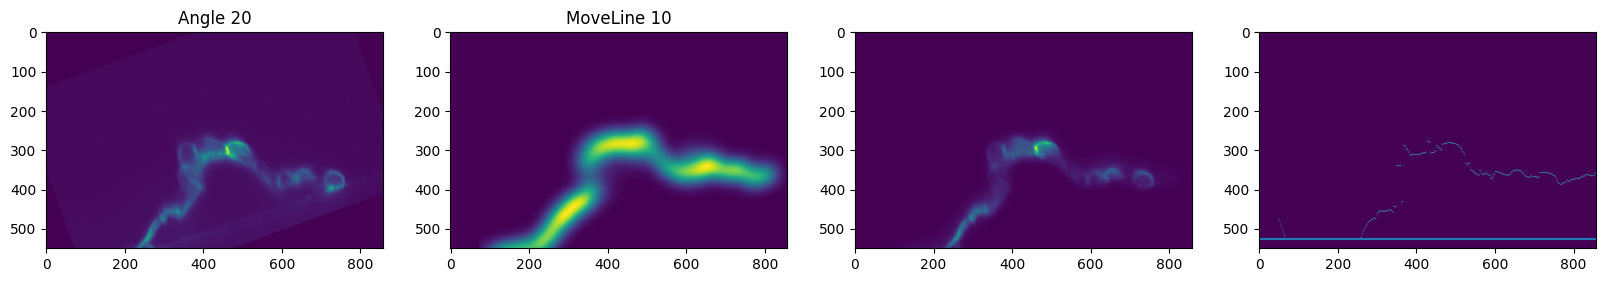

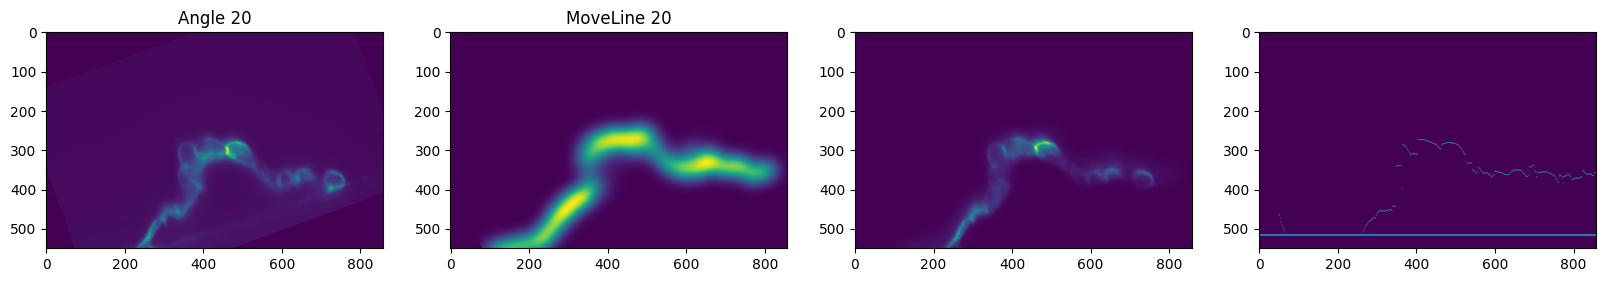

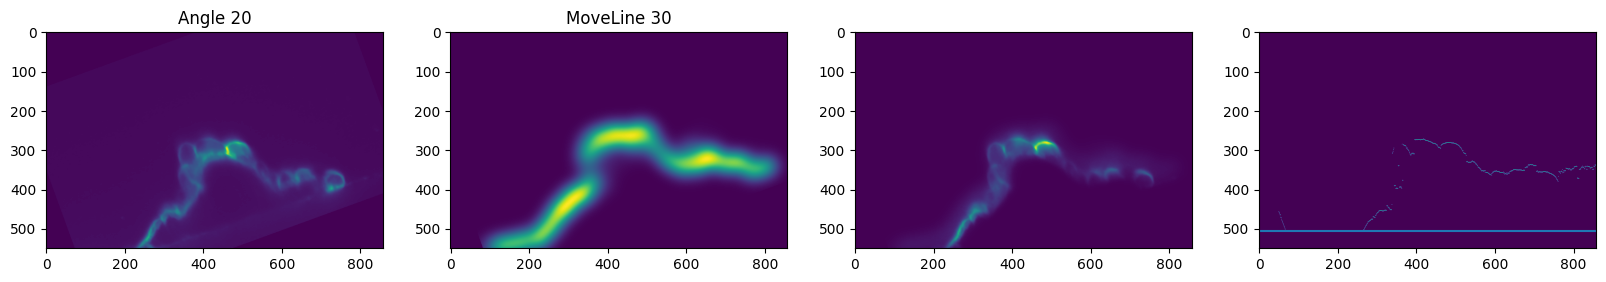

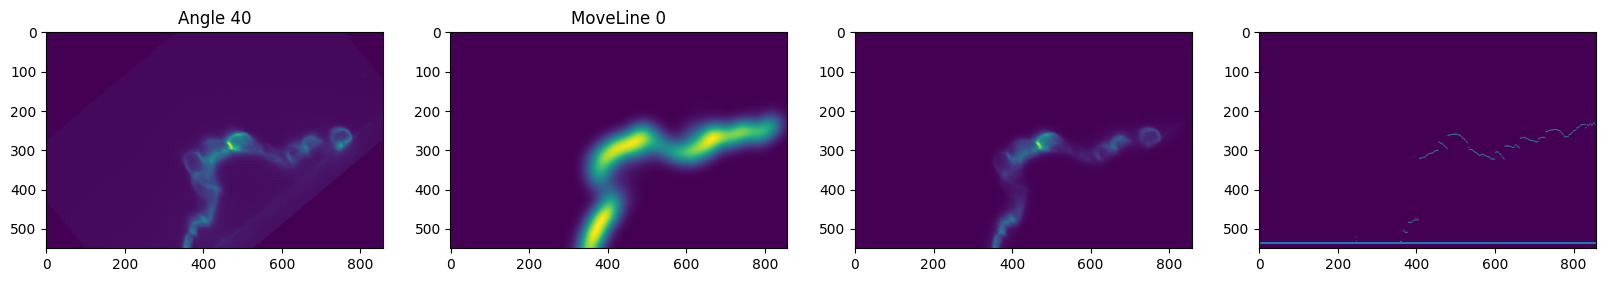

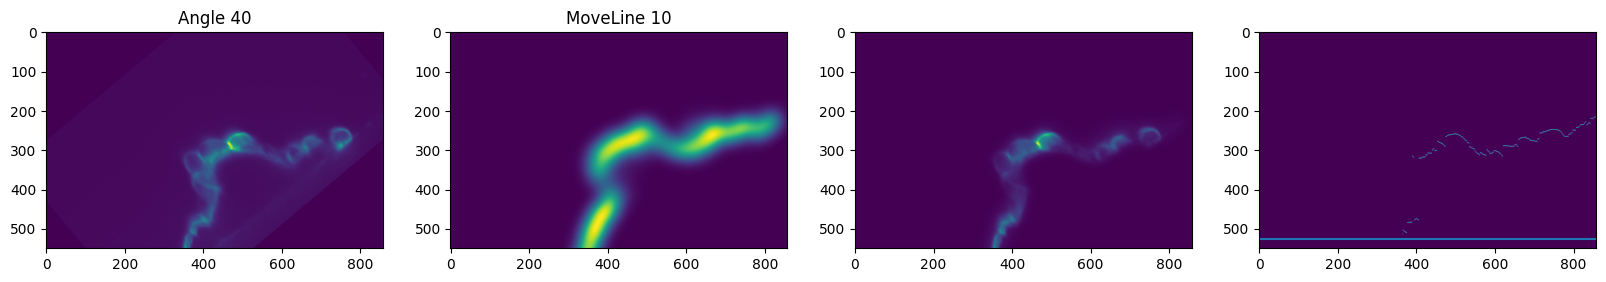

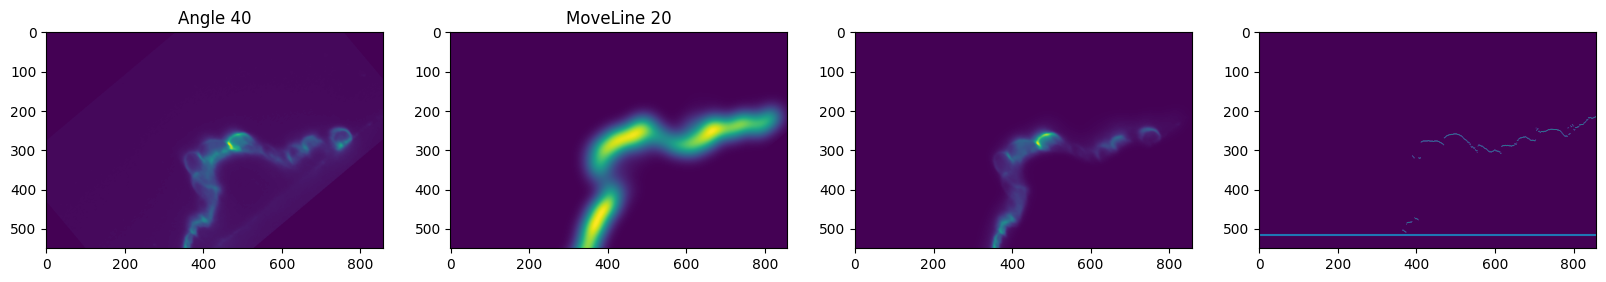

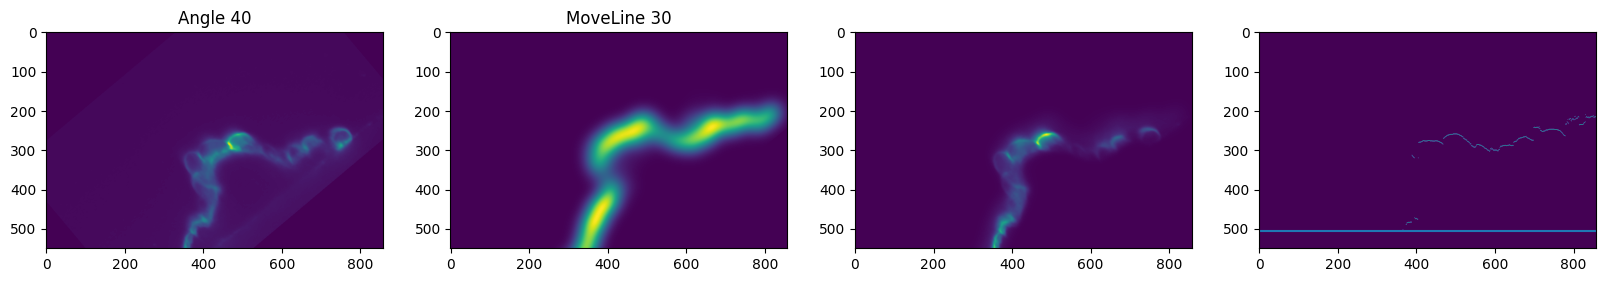

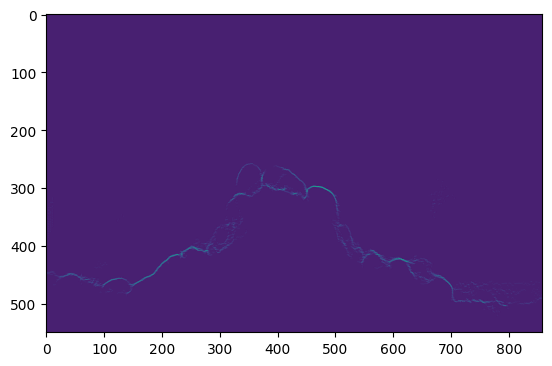

In [206]:
def find_maximus(epithelial, moveLine, margin=5):

    max_intensity_indices =  np.argmax(epithelial, axis=0)

    apical = np.zeros(epithelial.shape)
    apical[max_intensity_indices, np.array(list(range(epithelial.shape[1])))] = 1

    apical[-moveLine-margin:, :] = 0

    return apical

def super_apical(image, gaussian, angle = 40, moveLine = 20, plots=False):

    total_apical = np.zeros((image.shape))

    angles = [i for i in range(-angle, angle+1, 20)]

    moveLines = [i for i in range(0, moveLine+1, 10)]

    for angle in angles:
        rot_image = rotate(image, angle, reshape=False)
        rot_gaussian = rotate(gaussian, angle, reshape=True)

        for moveLine in moveLines:

            rot_gaussian_up = common_functions.move2D_array(rot_gaussian, moveLine)

            y_0 = np.array(rot_gaussian.shape[0])/2-np.array(image.shape[0])/2
            y_1 = np.array(rot_gaussian.shape[0])/2+np.array(image.shape[0])/2
            x_0 = np.array(rot_gaussian.shape[1])/2-np.array(image.shape[1])/2
            x_1 = np.array(rot_gaussian.shape[1])/2+np.array(image.shape[1])/2

            y_0, y_1, x_0, x_1 = int(y_0), int(y_1), int(x_0), int(x_1)

            rot_gaussian_up = rot_gaussian_up[y_0:y_1, x_0:x_1]

            rot_epithelial = rot_image*rot_gaussian_up

            margin = 15
            apical = find_maximus(rot_epithelial, moveLine, margin)

            
            if plots:
                cols=4
                rows=1
                plt.figure(figsize=(20, 10))
                plt.subplot(rows, cols, 1)
                plt.title(f'Angle {angle}')
                plt.imshow(rot_image)
                plt.subplot(rows, cols, 2)
                plt.title(f'MoveLine {moveLine}')
                plt.imshow(rot_gaussian_up)
                plt.subplot(rows, cols, 3)
                plt.imshow(rot_epithelial)
                plt.subplot(rows, cols, 4)
                plt.imshow(apical)
                plt.axhline(apical.shape[0]-moveLine-margin)


            # apical = apical * rot_gaussian_up
            apical = rotate(apical, -angle, reshape=False)

            total_apical += apical





    return total_apical

total_apical = super_apical(image_r[y], gaussian_r[y], angle=40, moveLine=30, plots=True);

plt.figure()
plt.imshow(common_functions.normalize_image(total_apical))
plt.show()

In [199]:
apical_dots_r = Parallel(n_jobs=-1)(delayed(super_apical)(im, i) for im, i in zip(image_r, gaussian_r))
apical_dots = np.transpose(apical_dots_r, axes=(1,2,0))

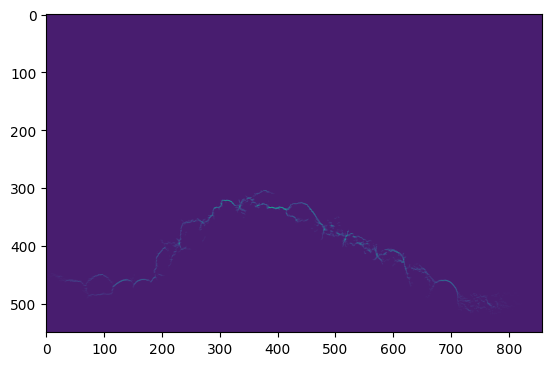

In [203]:
plt.imshow(apical_dots_r[y])

In [200]:
tiff.imwrite(f'{wd}_super_apical_function.tif', common_functions.normalize_image(apical_dots, 255).astype(np.uint16))

In [201]:
gaussian_dots = common_functions.get_3D_gaussian(apical_dots)
tiff.imwrite(f'{wd}_super_apical_function_gaussian.tif', common_functions.normalize_image(gaussian_dots, 255).astype(np.uint16))
